# ANALISIS DE SENTIMIENTO PARO NACIONAL - 21 NOVIEMBRE 
A traves de el machine learning se realizara un analisis de sentimiento del Paro Nacional del 21 Noviembre
Los datos han sido obtenidos a partir de web scrapping con herramienta Octoparse, la fuente de los datos fue la red social Twitter


In [1]:
#librerias
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans as sk_Kmeans
import indicoio
import repustate
import matplotlib.pyplot as plt
import nltk
import langid
from langdetect import detect
import textblob


In [2]:
#Armando el dataset

#Lectura de archivos
    #datasets
d1 = pd.read_csv('180.csv',sep=';',error_bad_lines=False,encoding = 'ISO-8859-1')
d2 = pd.read_csv('ingles.csv',sep=';',error_bad_lines=False,encoding = 'ISO-8859-1')
d3 = pd.read_csv('esp-paronuevo.csv',sep=';',error_bad_lines=False,encoding = 'ISO-8859-1')
d4 = pd.read_csv('ingles-paronuevo.csv',sep=';',error_bad_lines=False,encoding = 'ISO-8859-1')


    #polaridades
p1 = pd.read_csv('p_esp.csv')
p2 = pd.read_csv('p_eng.csv',error_bad_lines=False,encoding = 'ISO-8859-1')
p3 = pd.read_csv('espa-pol-nuevo.csv')
p4 = pd.read_csv('pol-ingles-nuevo.csv',error_bad_lines=False,encoding = 'ISO-8859-1')

#juntar polaridad en cada dataset
df_english = pd.concat([d2,p2],axis=1)
df_spanish = pd.concat([d1,p1],axis=1)
df_english2 = pd.concat([d4,p4],axis=1)
df_spanish2 = pd.concat([d3,p3],axis=1)
#rellenar los nan si existen
df_spanish['Polaridad'] = df_spanish['Polaridad'].fillna(0)
df_english['Polaridad'] = df_english['Polaridad'].fillna(0)
df_spanish2['Polaridad'] = df_spanish2['Polaridad'].fillna(0)
df_english2['Polaridad'] = df_english2['Polaridad'].fillna(0)

#Dar label de sentimiento - Positivo, Negativo, Neutral segun valor de la poralidad
def f(row):
    if row['Polaridad'] >= 0.05:
        row['Label'] = "Positive"
    elif row['Polaridad'] <= -0.05:
        row['Label'] = "Negative"
    else:
        row['Label'] = "Neutral"
    return row['Label']


df_spanish['Sentiment'] = df_spanish.apply(f,axis=1)
df_english['Sentiment'] = df_english.apply(f,axis=1)
df_spanish2['Sentiment'] = df_spanish.apply(f,axis=1)
df_english2['Sentiment'] = df_english.apply(f,axis=1)
#Dataset con todo junto
data = pd.concat([df_spanish, df_english,df_spanish2, df_english2 ])
data['Content']=data['Content'].apply(str)
data['Language'] = data['Content'].apply(detect)

import re
def  clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    return df
data = clean_text(data, "Content")


In [3]:
data.head(9)


,Name,ID,Content,Comments,Retweet,Likes,Polaridad,Sentiment,Language
0,Andrés Clavijo Rangel,ClavijoAndres83,a propsito de lo que est pasando en colombia l...,1.0,8,8,-0.975000,Negative,es
1,Efrapotter,efrapotter,y en t pas la polica coge ladronesni entre 20 ...,9.0,167,226,-0.909482,Negative,es
2,Felipe Cárdenas ??,Pizza_Sin_Pina,debo confesar que anoche sent miedo prepar mi ...,18.0,251,404,-0.975000,Negative,es
3,Heidy Sánchez,Heidy_UP,quiero denunciar a estos vndalos tirapiedras q...,18.0,384,384,-0.975000,Negative,es
4,Laura Sofia Parra,LauraSofiaC_,marchemos de una forma diferente disfrutemos e...,NaN,1,3,0.975000,Positive,es
5,Jonny Barco,jonnybarco,no ms falsos positivos no ms falsas banderas,NaN,13,27,0.975000,Positive,es
6,La Oreja Roja,LaOrejaRoja,en bogot uno de los vndalos fue atrapado por l...,33.0,889,1.0K,-0.975000,Negative,es
7,Indignados Colombia,ManosLimpiasCo,vamos todos con este ht para que todo el mundo...,2.0,44,46,0.002658,Neutral,es
8,Ed Pardo,pardocorp,saca un trapo blanco en tu ventana no te puede...,NaN,NaN,1,0.975000,Positive,es


In [4]:
data.groupby('Sentiment').size()

Sentiment
Negative    313
Neutral     218
Positive    130
dtype: int64

#  K- mean 
Para hacer una clasificacion de los sentimientos y ver como estos estan clasificados usamos el algoritmo de kmean que permite agrupar entre valores cercanos.

In [5]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd


In [6]:
from sklearn.cluster import KMeans as sk_Kmeans     

In [7]:
class KMeans:
    def __init__(self, k,puntos):
        self.k=k
        self.puntos=puntos
        self.centroids=np.copy(puntos[0:2])
        self.puntos=np.c_[puntos,np.zeros(len(puntos))]
        self.puntos[0][2]=0
        self.N=len(puntos)


    def EuclidianDistance(self,x1,y1,x2,y2): 
        return np.sqrt((x1-x2)**2  + (y1-y2)**2)
        
    
    def selectClusters(self):
        for i in range(self.N):
            d0=self.EuclidianDistance(self.puntos[i][0],self.puntos[i][1],self.centroids[0][0],self.centroids[0][1])
            d1=self.EuclidianDistance(self.puntos[i][0],self.puntos[i][1],self.centroids[1][0],self.centroids[1][1])
            if(d0<=d1):
                self.puntos[i][2]=0

            if(d1<d0):
                self.puntos[i][2]=1
            d0=0
            d1=0
    
    def updateCentroids(self):
        cx0=0
        cy0=0
        cx1=0
        cy1=0
        n0=0
        n1=0
        for i in range(self.N):
            if(self.puntos[i][2]==0):
                cx0+=self.puntos[i][0]
                cy0+=self.puntos[i][1]
                n0+=1
            if(self.puntos[i][2]==1):
                cx1+=self.puntos[i][0]
                cy1+=self.puntos[i][1]
                n1+=1
        self.centroids[0][0]=cx0/n0
        self.centroids[0][1]=cy0/n0
        self.centroids[1][0]=cx1/n1
        self.centroids[1][1]=cy1/n1


    def printData(self):
        print(self.puntos)
    
    def printCentroids(self):
        print(self.centroids)

    def applyNIterations(self,iterations):
        for i in range(iterations):
            self.calculateInertia()
            self.selectClusters()
            self.updateCentroids()
            

    def plotData(self):
        x0=[]
        x1=[]
        y0=[]
        y1=[]
        plt.figure()   
        for i in range(self.N):
            if(self.puntos[i][2]==0):
                x0.append(self.puntos[i][0])
                y0.append(self.puntos[i][1])

            if(self.puntos[i][2]==1):
                x1.append(self.puntos[i][0])
                y1.append(self.puntos[i][1])
        plt.scatter(x0, y0, color='b', label='0')
        plt.scatter(x1, y1, color='r', label='1')
        plt.legend()
        plt.show()
    
    def calculateInertia(self):
        suma=0
        for i in range(self.N):
            centroid=int(self.puntos[i][2])
            distance=self.EuclidianDistance(self.puntos[i][0],self.puntos[i][1],self.centroids[centroid][0],self.centroids[centroid][1])
            suma+=distance**2
        print("Inertia: "+str(suma))


In [8]:
def Plot(data,maxKClusters):
    inertias=list()
    for i in range(1,maxKClusters+1):
        myCluster=sk_Kmeans(n_clusters=i)
        myCluster.fit(data)

        inertias.append(myCluster.inertia_)
        
    plt.figure() 
    x=[i for i in range(1,maxKClusters+1)]
    y=[i for i in inertias]
    plt.plot(x,y, 'ro-', markersize=8, lw=2)
    plt.grid(True)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.show()

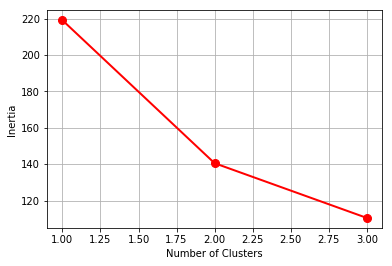

In [9]:
p12 = pd.read_csv('p_esp.csv')
p22 = pd.read_csv('p_eng.csv',sep=';',error_bad_lines=False,encoding = 'ISO-8859-1')
data1 = pd.concat([p12,p22,p3,p4],axis=1)
data1['Polaridad'] = data1['Polaridad'].fillna(0)
Plot(data1,3)


#elbow graph

In [10]:
clustering=KMeans(2,data1)
clustering.applyNIterations(100)


Inertia: 350.05931517878327
Inertia: 117.93590314162529
Inertia: 117.68336459815912
Inertia: 117.68336459815912
Inertia: 117.68336459815912
Inertia: 117.68336459815912
Inertia: 117.68336459815912
Inertia: 117.68336459815912
Inertia: 117.68336459815912
Inertia: 117.68336459815912
Inertia: 117.68336459815912
Inertia: 117.68336459815912
Inertia: 117.68336459815912
Inertia: 117.68336459815912
Inertia: 117.68336459815912
Inertia: 117.68336459815912
Inertia: 117.68336459815912
Inertia: 117.68336459815912
Inertia: 117.68336459815912
Inertia: 117.68336459815912
Inertia: 117.68336459815912
Inertia: 117.68336459815912
Inertia: 117.68336459815912
Inertia: 117.68336459815912
Inertia: 117.68336459815912
Inertia: 117.68336459815912
Inertia: 117.68336459815912
Inertia: 117.68336459815912
Inertia: 117.68336459815912
Inertia: 117.68336459815912
Inertia: 117.68336459815912
Inertia: 117.68336459815912
Inertia: 117.68336459815912
Inertia: 117.68336459815912
Inertia: 117.68336459815912
Inertia: 117.6833645

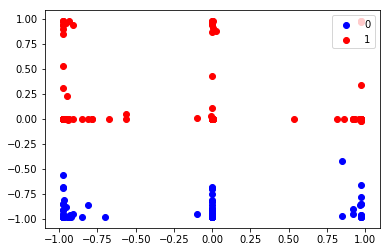

In [11]:
clustering.plotData()

In [12]:
df_es = data.loc[data['Language'] == "es"]
df_en = data.loc[data['Language'] == "en"]

In [14]:
#stopwords ingles
stopwords = nltk.corpus.stopwords.words('english')

RE_stopwords = r'\b(?:{})\b'.format('|'.join(stopwords))

words = (df_en.Content
           .str.lower()
           .replace([r'\|',r'\&',r'\-',r'\.',r'\,',r'\'', RE_stopwords], [' ', '','','','','',''], regex=True)
           .str.cat(sep=' ')
           .split()
)

from collections import Counter

# generate DF out of Counter
rslt = pd.DataFrame(Counter(words).most_common(10),
                    columns=['Word', 'Frequency']).set_index('Word')
rslt

,Frequency
Word,
paronacional,120
colombia,96
people,43
police,41
protests,38
government,37
bogota,32
paronacionalcolombia,32
strike,31


In [16]:
#stopwords español
stopwords = nltk.corpus.stopwords.words('Spanish')

RE_stopwords = r'\b(?:{})\b'.format('|'.join(stopwords))

words = (df_es.Content
           .str.lower()
           .replace([r'\|',r'\&',r'\-',r'\.',r'\,',r'\'', RE_stopwords], [' ', '','','','','',''], regex=True)
           .str.cat(sep=' ')
           .split()
)

from collections import Counter

# generate DF out of Counter
rslt = pd.DataFrame(Counter(words).most_common(10),
                    columns=['Word', 'Frequency']).set_index('Word')
rslt

,Frequency
Word,
paro,157
nacional,130
23nparonacional,74
gobierno,38
ms,37
noviembre,35
colombia,34
miedo,33
21,32


In [ ]:
sns.lmplot(x='df_en',y='polarity',data=dffilter,fit_reg=True,scatter=True, height=10,palette="mute") 